In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec

In [207]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = {
    'main': '#CFD923',
    'second': '#EB5D18',
    'extra': '#E0E0E0'
}

# brunoyam_cmap = ListedColormap([colors['main'], colors['second'], colors['extra']])
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

cdict = {
    'red': (
            (0, inter_from_256(224), inter_from_256(224)),
            (0.5, inter_from_256(207), inter_from_256(207)),
            (1, inter_from_256(235), inter_from_256(235)),
    ),
    'green': (
        (0, inter_from_256(224), inter_from_256(224)),
        (0.5, inter_from_256(217), inter_from_256(217)),
        (1, inter_from_256(93), inter_from_256(93)),
    ),
    'blue': (
        (0, inter_from_256(224), inter_from_256(224)),
        (0.5, inter_from_256(35), inter_from_256(35)),
        (1, inter_from_256(24), inter_from_256(24)),
        
    ),
           
}

brunoyam_cmap = LinearSegmentedColormap('brunoyam_cmap', segmentdata=cdict)

plt.rcParams.update({'font.family':'Closer'})
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [18]:
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
russian_stopwords = set(russian_stopwords)

from tqdm.auto import tqdm
tqdm.pandas()

In [111]:
df = pd.read_csv('data/news.csv')
df = df[['source', 'title', 'text', 'rubric']]
df = df.dropna()
df

,source,title,text,rubric
0,lenta.ru,Синий богатырь,В 1930-е годы Советский Союз охватила лихорадк...,Экономика
1,lenta.ru,Загитова согласилась вести «Ледниковый период»,Олимпийская чемпионка по фигурному катанию Ал...,Спорт
2,lenta.ru,Объяснена опасность однообразного питания,Российский врач-диетолог Римма Мойсенко объясн...,Из жизни
3,lenta.ru,«Предохраняться? А зачем?»,В 2019 году телеканал «Ю» запустил адаптацию з...,Интернет и СМИ
4,lenta.ru,Ефремов систематически употреблял наркотики,Актер Михаил Ефремов систематически употребл...,Культура
...,...,...,...,...
4505,lenta.ru,Болгария начала получать газ из «Турецкого пот...,C 1 января Болгария начала получать российский...,Экономика
4506,lenta.ru,В России изменили правила содержания животных,В России вступили в силу новые правила содержа...,Россия
4507,lenta.ru,Лазарев объяснил свой проигрыш на «Евровидении»,Российский певец Сергей Лазарев объяснил сво...,Культура
4508,lenta.ru,Трамп заявил о нежелании воевать с Ираном,Президент США Дональд Трамп заявил о нежелан...,Мир


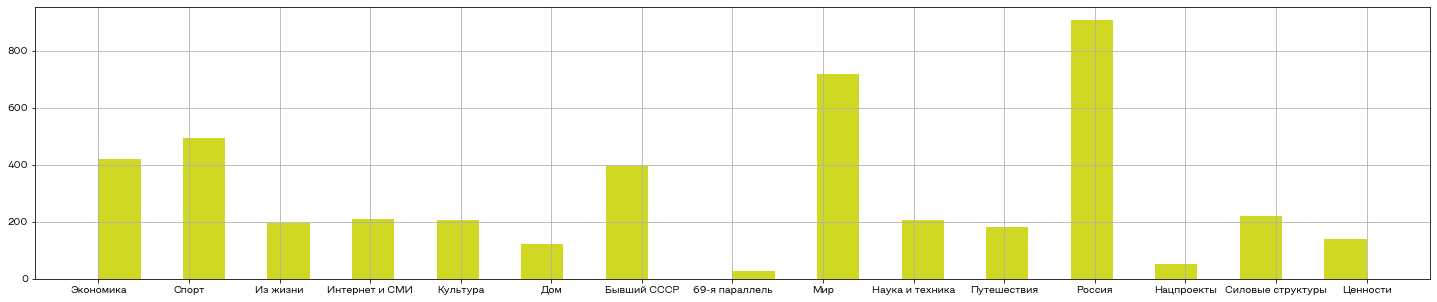

In [183]:
df.rubric.hist(figsize=(25, 5), bins=len(df.rubric.unique()) * 2, color=colors['main'])
plt.savefig('../images/news_hist.jpg')

In [112]:
def stem_sentence(sentence):
    stemmed_words = []
    for word in sentence.split():
        stemmed_words.append(Porter.stem(word))
    return ' '.join(stemmed_words)

def remove_punctuation(sentence):
    lower_sentence = sentence.lower()
    return re.sub(r'[^\w\s]', '', lower_sentence)

lemmatizer = pymorphy2.MorphAnalyzer()
def lemmatize_sentence(sentence):
    lemmatized_words = []
    for word in sentence.split():
        lemmatized_words.append(lemmatizer.parse(word)[0].normal_form)
    return ' '.join(lemmatized_words)

def preprocess_sentence_lemmatize(sentence):
    return lemmatize_sentence(remove_punctuation(sentence))

def preprocess_sentence_stem(sentence):
    return stem_sentence(remove_punctuation(sentence))

In [113]:
df['preprocessed_text'] = df.text.progress_apply(lambda x: preprocess_sentence_lemmatize(x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4503/4503 [02:08<00:00, 34.95it/s]


In [114]:
df['rubric'] = pd.Categorical(df.rubric)
# df['rubric_code'] = df['rubric'].cat.codes

In [117]:
train, test = train_test_split(df, random_state=0, train_size=0.8)
x_train = train.preprocessed_text
y_train = train.rubric
x_test = test.preprocessed_text
y_test = test.rubric
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3602,), (3602,), (901,), (901,))

## Модели

In [208]:
def plot_result(model, x_test, y_test):
    y_pred = pipeline.predict(x_test)
    mat = confusion_matrix(y_test, y_pred)
    df_matrix = pd.DataFrame(mat, index=df.rubric.cat.categories, columns=df.rubric.cat.categories)
    result = {
        # 'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=None),
        'recall': recall_score(y_test, y_pred, average=None),
        'f1': f1_score(y_test, y_pred, average=None),
    }
    result = pd.DataFrame(result, index=df.rubric.cat.categories)
    
    fig, ax = plt.subplots(1, 2, figsize=(30, 5))
    ax[0].set_title(f'Метрики, f1_average={f1_score(y_test, y_pred, average="macro"):.3f}')
    sns.heatmap(result, annot=True, ax=ax[0], cmap=brunoyam_cmap)
    
    ax[1].set_title('Confusion matrix')
    sns.heatmap(df_matrix, annot=True, ax=ax[1], cmap=brunoyam_cmap)

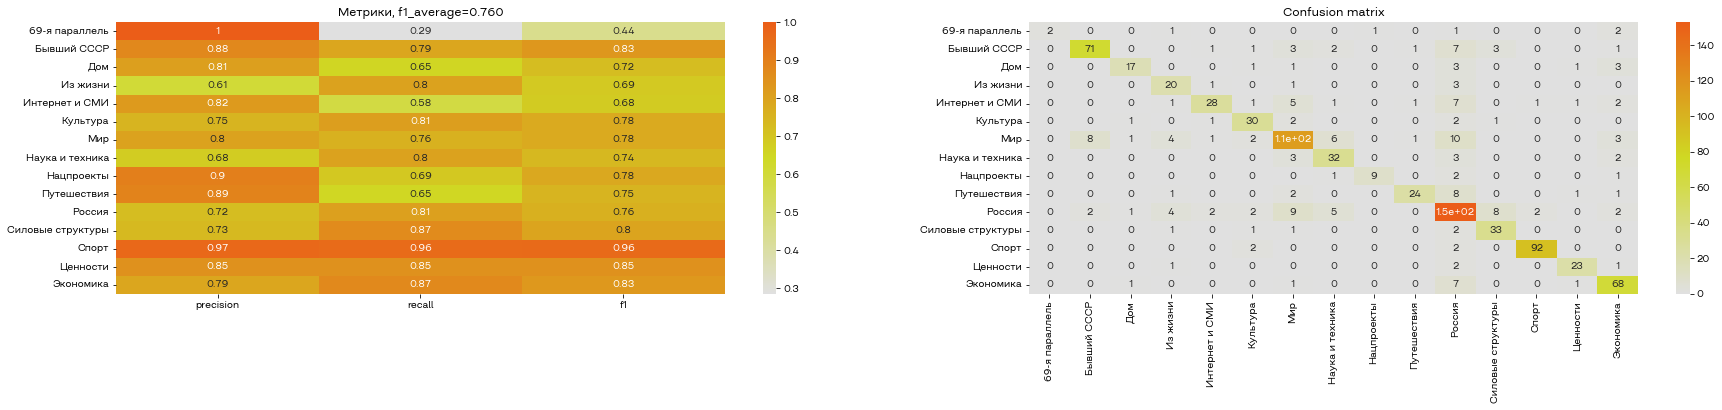

In [209]:
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('LogisticRegression', LogisticRegression(max_iter=1000))
])

pipeline.fit(x_train, y_train)
plot_result(pipeline, x_test, y_test)
plt.savefig('../images/news_logreg_bow.jpg')

C:\Users\koval\anaconda3\envs\brunoyam-ds-online\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


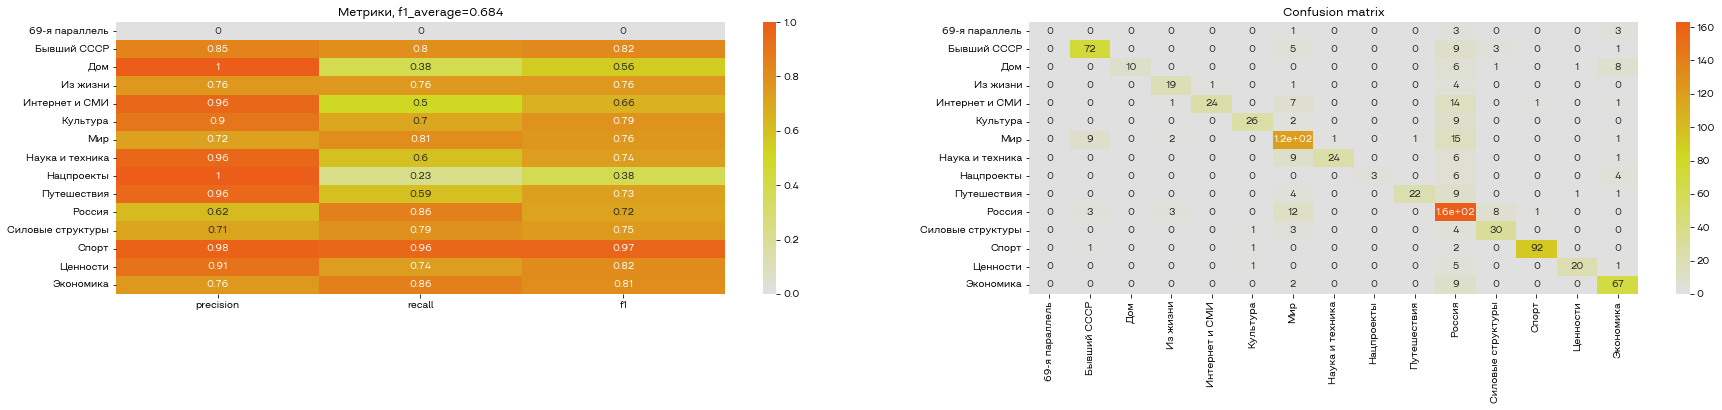

In [213]:
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('TfidfTransformer', TfidfTransformer()),
    ('LogisticRegression', LogisticRegression(max_iter=1000))
])

pipeline.fit(x_train, y_train)
plot_result(pipeline, x_test, y_test)
plt.savefig('../images/news_logreg_tfidf.jpg')

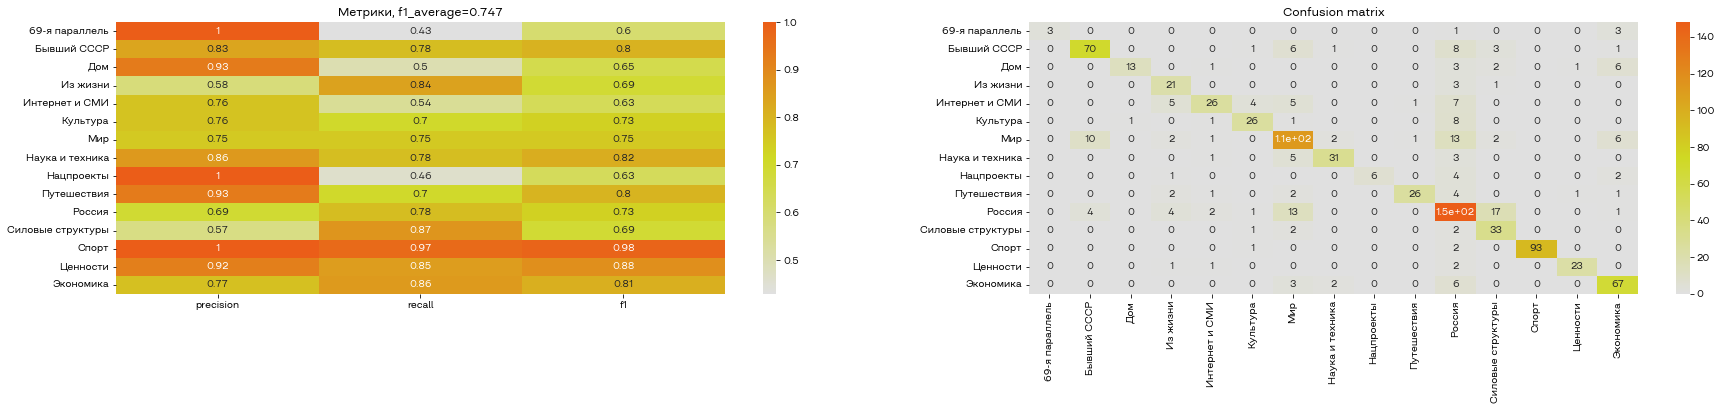

In [211]:
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('TfidfTransformer', TfidfTransformer()),
    ('NB', MultinomialNB(alpha=0.01))
])

pipeline.fit(x_train, y_train)
plot_result(pipeline, x_test, y_test)

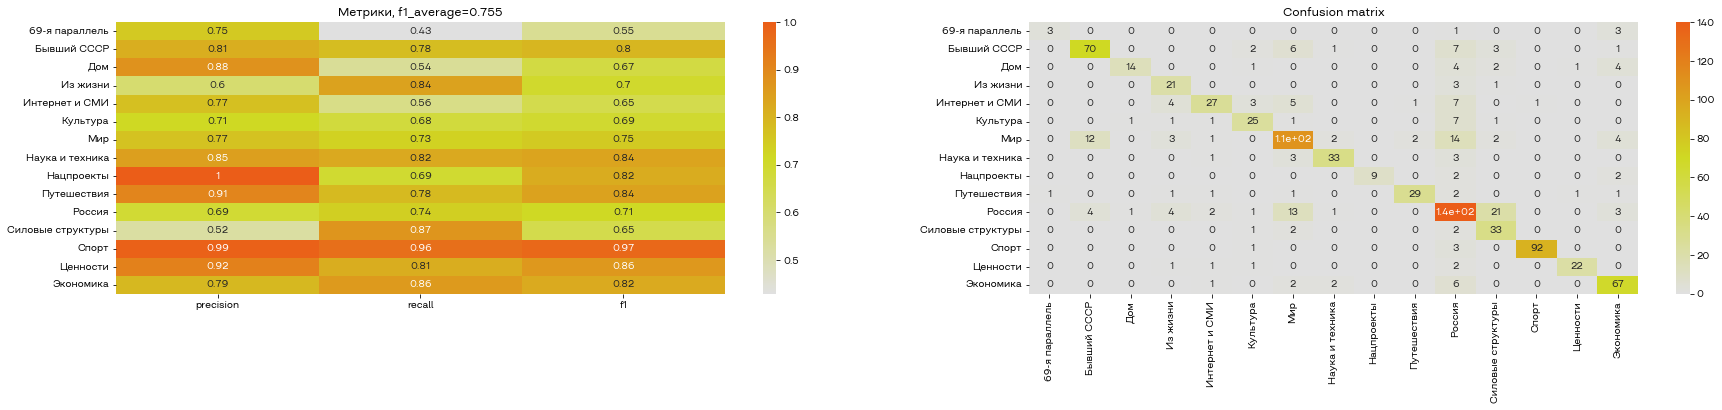

In [212]:
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('NB', MultinomialNB(alpha=0.01))
])

pipeline.fit(x_train, y_train)
plot_result(pipeline, x_test, y_test)

## Word2Vec

In [250]:
sentences = []
for sentence in df.preprocessed_text:
    sentences.append(sentence.split())

In [252]:
word2vec = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1,)

In [289]:
word2vec.wv.most_similar(['интернет'])

[('форма', 0.9428954124450684),
 ('приложение', 0.9328800439834595),
 ('существующий', 0.9318660497665405),
 ('учиться', 0.9302136301994324),
 ('почва', 0.9265796542167664),
 ('оптимизм', 0.9217283129692078),
 ('отдыхать', 0.9205290675163269),
 ('попадать', 0.9198291301727295),
 ('кожа', 0.9183829426765442),
 ('туалет', 0.9172804951667786)]